In [5]:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import re
import nltk
nltk . download ('stopwords ')

from sklearn . model_selection import train_test_split
from sklearn . feature_extraction . text import TfidfVectorizer
from nltk . corpus import stopwords
from nltk . stem import SnowballStemmer

[nltk_data] Error loading stopwords : Package 'stopwords ' not found
[nltk_data]     in index


In [6]:
df = pd.read_csv('Twitter_Data.csv')
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [8]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


In [9]:
def text_normalize ( text ) :
    # Lowercasing
    text = text . lower ()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt [\s]+ ', '', text )

    # Hyperlinks removal
    text = re.sub(r'https ?:\/\/.*[\ r\n]* ', '', text )

    # Punctuation removal
    text = re.sub (r'[^\ w\s]', '', text )

    # Remove stopwords
    stop_words = set ( stopwords . words ('english ') )

    words = text . split ()
    words = [ word for word in words if word not in stop_words ]
    text = ' '. join ( words )

    # Stemming
    stemmer = SnowballStemmer ('english ')
    words = text . split ()
    words = [ stemmer . stem ( word ) for word in words ]
    text = ' '. join ( words )

    return text

In [11]:
vectorizer = TfidfVectorizer ( max_features =2000)
X = vectorizer . fit_transform (df['clean_text']) . toarray ()

In [ ]:
X_b = np.concatenate([np.ones((X.shape[0], 1)), X], axis = 1)
X_b

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [13]:
n_classes = df['category']. nunique ()
n_samples = df['category']. size

y = df['category']. to_numpy () + 1
y = y. astype (np. uint8 )
y_encoded = np.zeros((n_samples, n_classes))
y_encoded [np. arange ( n_samples ) , y] = 1

In [14]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (
    X_b , y_encoded ,
    test_size = val_size ,
    random_state = random_state ,
    shuffle = is_shuffle
)

X_train , X_test , y_train , y_test = train_test_split (
    X_train , y_train ,
    test_size = test_size ,
    random_state = random_state ,
    shuffle = is_shuffle
)

In [15]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z/exp_z.sum(axis = 1)[:, None]

def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat

def compute_loss(y_hat, y):
    n = y.size
    return (-1/n)*np.sum(y*np.log(y_hat))

def compute_gradient (X, y, y_hat ):
    n = y. size
    return np.dot(X.T, ( y_hat - y) ) / n

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis = 1) == np.argmax(y, axis = 1)).mean()
    return acc

def update_theta(theta, gradient, lr):
    return theta - gradient*lr

In [16]:
lr = 0.1
epochs = 200
batch_size = X_train . shape [0]
n_features = X_train . shape [1]

np. random . seed ( random_state )
theta = np. random . uniform (
    size =( n_features , n_classes )
)

In [18]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range ( epochs ) :
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range (0 , X_train . shape [0] , batch_size ) :
        X_i = X_train [i:i+ batch_size ]
        y_i = y_train [i:i+ batch_size ]

        y_hat = predict (X_i , theta )
        train_loss = compute_loss (y_hat , y_i )

        gradient = compute_gradient (X_i , y_i , y_hat )

        theta = update_theta (theta , gradient , lr)


        train_batch_losses . append ( train_loss )
        train_acc = compute_accuracy ( X_train , y_train , theta )
        train_batch_accs . append ( train_acc )

        y_val_hat = predict (X_val , theta )
        val_loss = compute_loss ( y_val_hat , y_val )
        val_batch_losses . append ( val_loss )

        val_acc = compute_accuracy (X_val , y_val , theta )
        val_batch_accs . append ( val_acc )

        train_batch_loss = sum ( train_batch_losses ) / len (
        train_batch_losses )
        val_batch_loss = sum ( val_batch_losses ) / len ( val_batch_losses )
        train_batch_acc = sum ( train_batch_accs ) / len ( train_batch_accs )
        val_batch_acc = sum ( val_batch_accs ) / len ( val_batch_accs )

    train_losses . append ( train_batch_loss )
    val_losses . append ( val_batch_loss )
    train_accs . append ( train_batch_acc )
    val_accs . append ( val_batch_acc )

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')



EPOCH 1:	Training loss: 0.377	Validation loss: 0.376

EPOCH 2:	Training loss: 0.377	Validation loss: 0.376

EPOCH 3:	Training loss: 0.377	Validation loss: 0.376

EPOCH 4:	Training loss: 0.376	Validation loss: 0.375

EPOCH 5:	Training loss: 0.376	Validation loss: 0.375

EPOCH 6:	Training loss: 0.376	Validation loss: 0.375

EPOCH 7:	Training loss: 0.375	Validation loss: 0.374

EPOCH 8:	Training loss: 0.375	Validation loss: 0.374

EPOCH 9:	Training loss: 0.375	Validation loss: 0.374

EPOCH 10:	Training loss: 0.374	Validation loss: 0.373

EPOCH 11:	Training loss: 0.374	Validation loss: 0.373

EPOCH 12:	Training loss: 0.374	Validation loss: 0.373

EPOCH 13:	Training loss: 0.374	Validation loss: 0.373

EPOCH 14:	Training loss: 0.373	Validation loss: 0.372

EPOCH 15:	Training loss: 0.373	Validation loss: 0.372

EPOCH 16:	Training loss: 0.373	Validation loss: 0.372

EPOCH 17:	Training loss: 0.372	Validation loss: 0.372

EPOCH 18:	Training loss: 0.372	Validation loss: 0.371

EPOCH 19:	Training

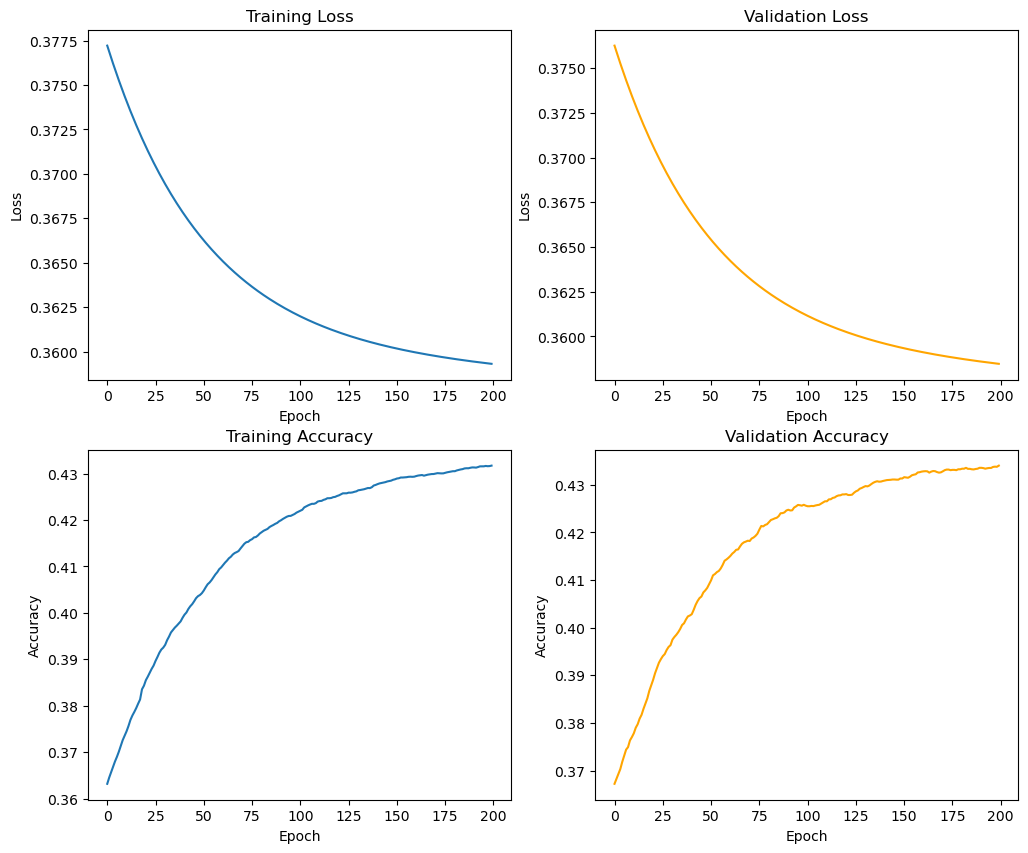

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [21]:
val_set_acc = compute_accuracy (X_val , y_val , theta )
test_set_acc = compute_accuracy ( X_test , y_test , theta )
print ('Evaluation on validation and test set :')
print (f'Accuracy : { val_set_acc }')
print (f'Accuracy : { test_set_acc }')

Evaluation on validation and test set :
Accuracy : 0.4340369393139842
Accuracy : 0.4322881511934712
